Pomysłem na rozwiązanie problemu rekomendacji jest stworzenie sieci neuronowej, która oceni filmy zgodnie z preferencjami danego użytkownika.

 W tym celu planuję przygotować dane, aby wektor wejściowy do sieci zawierał zarówno reprezentację ocenianego filmu, jak i reprezentację użytkownika. Posiadam jedynie dane dotyczące preferencji użytkowników, zatem będzie to jedyny wyznacznik.

In [1]:
import pandas as pd
movie=pd.read_csv(r"ml-25m\movies.csv")
rat=pd.read_csv(r"ml-25m\ratings.csv")
tag=pd.read_csv(r"ml-25m\tags.csv")
gs=pd.read_csv(r"ml-25m\genome-scores.csv")
gt=pd.read_csv(r"ml-25m\genome-tags.csv")

**Zaczniemy od reorganizacji danych z tabeli genome_scores.**

Dostaracza ona dużo informacji na temat treści filmu. Filmy są tam ocenione pod względem zawartości ponad 1000 tagów. Są podane jednak w oszczędnej dla pamięci formie, więc zreorganizuję tabele aby dostoswać ją pod wygodny wektor danych.
 

In [2]:

data = gs.pivot(index='movieId', columns='tagId', values='relevance')
data.columns.name = None
data.head()

,1,2,3,4,5,6,7,8,9,10,...,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02875,0.02375,0.06250,0.07575,0.14075,0.14675,0.06350,0.20375,0.2020,0.03075,...,0.04050,0.01425,0.03050,0.03500,0.14125,0.05775,0.03900,0.02975,0.08475,0.02200
2,0.04125,0.04050,0.06275,0.08275,0.09100,0.06125,0.06925,0.09600,0.0765,0.05250,...,0.05250,0.01575,0.01250,0.02000,0.12225,0.03275,0.02100,0.01100,0.10525,0.01975
3,0.04675,0.05550,0.02925,0.08700,0.04750,0.04775,0.04600,0.14275,0.0285,0.03875,...,0.06275,0.01950,0.02225,0.02300,0.12200,0.03475,0.01700,0.01800,0.09100,0.01775
4,0.03425,0.03800,0.04050,0.03100,0.06500,0.03575,0.02900,0.08650,0.0320,0.03150,...,0.05325,0.02800,0.01675,0.03875,0.18200,0.07050,0.01625,0.01425,0.08850,0.01500
5,0.04300,0.05325,0.03800,0.04100,0.05400,0.06725,0.02775,0.07650,0.0215,0.02975,...,0.05350,0.02050,0.01425,0.02550,0.19225,0.02675,0.01625,0.01300,0.08700,0.01600


**Kolejnym celem jest utworzenie reprezentacji uzytkownika**

Postanowiłem zrobić to poprzez wektor jego ulubionych filmów, jako ze każdy film jest okreslony przez ponad 1000 cech postanowilem zmiejszyć ich liczbę i uszeregowac je wzgledem ważności i wybrać tylko te najwazniejsze do wektora jego preferencji. Chciałem aby sieć przyjmowała na wejsciu wektor reprezentujący użytkownika złożony z pewnej liczby jego ulubionych filmów które będą reprezentowane przez x najważniejszych cech, oraz wektor filmu do oceny stworzony w podobny sposób

[0.14905495 0.22326949 0.28168725 0.32124008 0.35382191 0.38187087
 0.40660537 0.4287136  0.44887958 0.46572842 0.48076429 0.49415438
 0.50713443 0.51925706 0.53084176 0.54110816 0.55019388 0.5590928
 0.56708517 0.57490315 0.58210175 0.58900122 0.5957148  0.6020578
 0.60809961 0.61370185 0.61891793 0.62385819 0.62871809 0.63337182
 0.63795321 0.64222108 0.64622722 0.65003545 0.65363232 0.65719857
 0.66064083 0.66398161 0.66722515 0.67033967 0.67334663 0.67630795
 0.67920199 0.68202228 0.6847787  0.6875202  0.69015011 0.6926625
 0.69512139 0.69747987 0.69978047 0.7020391  0.70425519 0.7064292
 0.70855479 0.71064803 0.71266636 0.71464999 0.71655757 0.71843521
 0.72028752 0.72208095 0.7238483  0.72559834 0.72731104 0.72900487
 0.73065549 0.7322885  0.73386187 0.73540445 0.73692952 0.73842463
 0.73989377 0.74134355 0.74276857 0.74417746 0.74556682 0.74694296
 0.74829299 0.74962729 0.75092486 0.75220516 0.75348094 0.75471826
 0.75594771 0.75716983 0.75838042 0.75956915 0.76074749 0.76191867

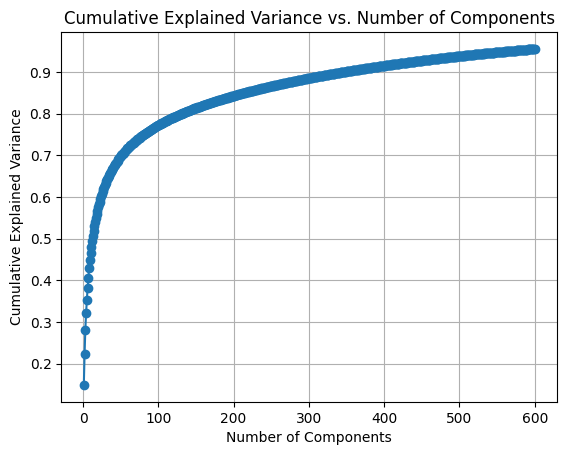

In [4]:
import numpy as np
from sklearn.decomposition import PCA
n_components = 600

pca = PCA(n_components=n_components)
pca.fit(data)

explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
print(cumulative_explained_variance)
import matplotlib.pyplot as plt

plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.grid()
plt.show()


Jak widać wyzej przy 600 cechach, zachowujemy prawie 96% informacji,
jednak wystarczy jedynie 25 cech aby zachować około 60% informacji.
Postanowiłem że wektory wejściowe będą złożone z 50 cech filmu ocenianego i 25 filmów należących do ulubionych uzytkownika.

In [3]:
import numpy as np
from sklearn.decomposition import PCA
n_components = 50


pca = PCA(n_components=n_components)
pca.fit(data)

explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
print(cumulative_explained_variance)


[0.14905495 0.22326949 0.28168725 0.32124008 0.35382191 0.38187087
 0.40660537 0.4287136  0.44887958 0.46572842 0.48076429 0.49415438
 0.50713443 0.51925706 0.53084176 0.54110816 0.55019388 0.5590928
 0.56708517 0.57490315 0.58210175 0.58900122 0.5957148  0.6020578
 0.60809961 0.61370185 0.61891792 0.62385819 0.62871809 0.63337182
 0.63795321 0.64222107 0.6462272  0.6500354  0.65363207 0.65719814
 0.66064009 0.66398077 0.66722388 0.67033767 0.67334408 0.67630513
 0.67919728 0.68201516 0.68476915 0.68750818 0.69013487 0.69264123
 0.69508628 0.69742814]


In [6]:
for i, explained_variancex in enumerate(explained_variance):
    print(f"Komponent główny {i+1}: Wyjaśniona wariancja = {explained_variancex:.4f}, Kumulatywna wyjaśniona wariancja = {cumulative_explained_variance[i]:.4f}")

Komponent główny 1: Wyjaśniona wariancja = 0.1491, Kumulatywna wyjaśniona wariancja = 0.1491
Komponent główny 2: Wyjaśniona wariancja = 0.0742, Kumulatywna wyjaśniona wariancja = 0.2233
Komponent główny 3: Wyjaśniona wariancja = 0.0584, Kumulatywna wyjaśniona wariancja = 0.2817
Komponent główny 4: Wyjaśniona wariancja = 0.0396, Kumulatywna wyjaśniona wariancja = 0.3212
Komponent główny 5: Wyjaśniona wariancja = 0.0326, Kumulatywna wyjaśniona wariancja = 0.3538
Komponent główny 6: Wyjaśniona wariancja = 0.0280, Kumulatywna wyjaśniona wariancja = 0.3819
Komponent główny 7: Wyjaśniona wariancja = 0.0247, Kumulatywna wyjaśniona wariancja = 0.4066
Komponent główny 8: Wyjaśniona wariancja = 0.0221, Kumulatywna wyjaśniona wariancja = 0.4287
Komponent główny 9: Wyjaśniona wariancja = 0.0202, Kumulatywna wyjaśniona wariancja = 0.4489
Komponent główny 10: Wyjaśniona wariancja = 0.0168, Kumulatywna wyjaśniona wariancja = 0.4657
Komponent główny 11: Wyjaśniona wariancja = 0.0150, Kumulatywna wyjaś

DataFrame reduced_df zawiera cechy z analizy PCA przypisane do id filmu.

In [4]:
reduced_features = pca.transform(data)
reduced_df = pd.DataFrame(reduced_features, index=data.index, columns=[f"PC{i}" for i in range(1, n_components + 1)])
print(reduced_df)

              PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
movieId                                                                         
1        0.796514  2.212839 -2.489444  1.624747  0.984763  1.168046 -0.203300   
2       -1.541922  1.597864 -1.113613  1.302526 -0.196336  0.191809 -0.026161   
3       -1.506092 -0.010220 -0.605981 -0.316252  0.330972  0.334078  0.048253   
4       -1.293604 -0.775662 -0.926582 -0.384600  0.103713 -0.345682  0.683775   
5       -1.694557 -0.185986 -1.204239 -0.149549  0.470713  0.053199  0.385026   
...           ...       ...       ...       ...       ...       ...       ...   
205072  -0.034354  1.189431 -0.941385  0.439289  1.349124  0.065643 -0.668149   
205076  -0.294929 -1.243930 -0.833182 -0.320838  0.265652  0.273416 -0.106014   
205383   0.569254  0.952059  0.161266 -0.542846  0.214419  0.119859 -0.036601   
205425   1.551432  1.517558  0.109042 -0.184095  1.932083  0.367802 -0.280007   
206499   0.212250  1.392884 

**Scalenie danych dotyczacacy ocen z tymi dotyczacymi treści.**

Postanowiłem usunąć dane dotyczące daty, ponieważ ta cecha wydaje się znancząca głównie w wypadku aktualnych danych, aby zauwazyć współczesne trendy, a dane które posiadam są juz dosyć stare. Jeśli chodzi o wykorzystanie sekwencji ogladania filmów, uznałem że nie jest to szczególnie ważny czynnik przy takim problemie.

In [5]:
rat = rat.drop("timestamp", axis=1)
merged_table = rat.merge(reduced_df, on='movieId', how='left')
merged_table

,userId,movieId,rating,PC1,PC2,PC3,PC4,PC5,PC6,PC7,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
0,1,296,5.0,4.790098,2.207694,2.002849,-0.806388,2.117197,0.731730,-0.099305,...,0.330946,0.351850,-0.366988,-0.279910,0.368720,-0.277067,0.184883,-0.298386,-0.112829,0.039205
1,1,306,3.5,2.693426,-1.425561,-0.187578,1.324501,-0.620035,0.422823,0.742552,...,-0.358853,-0.336570,-0.224734,0.151126,0.014946,-0.237259,-0.033414,-0.044286,-0.072966,-0.248112
2,1,307,5.0,2.663506,-1.833673,0.306733,1.546391,-0.493952,0.021804,0.473427,...,-0.301222,-0.208397,-0.364836,-0.014559,-0.211932,-0.176840,0.032193,0.300339,-0.163430,-0.359288
3,1,665,5.0,2.263750,-0.978720,-0.029237,0.822817,-0.605279,0.310908,-1.275393,...,-0.227383,0.122355,-0.329824,0.029782,0.015864,-0.026636,0.215110,-0.316799,-0.106783,-0.178361
4,1,899,3.5,0.933350,-0.077969,-1.643742,0.459915,0.592612,1.574695,-0.545392,...,-0.015386,-0.125579,-0.190540,0.078930,0.321402,-0.014826,-0.226755,0.223695,0.159705,0.301309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25000090,162541,50872,4.5,0.559187,1.273428,-2.321054,1.638386,0.761749,1.118073,0.543187,...,0.081112,0.054456,0.129290,0.189069,0.220461,-0.001408,-0.025611,0.412167,-0.129255,-0.645899
25000091,162541,55768,2.5,-1.746066,0.031802,-0.625601,0.815487,0.446195,0.708977,-0.206828,...,-0.059279,-0.032596,-0.044094,0.230373,0.027738,-0.082356,0.017948,0.007116,-0.047617,0.050319
25000092,162541,56176,2.0,-2.387714,0.071047,-0.662184,0.240420,0.387865,0.295560,-0.066649,...,-0.065120,0.043738,-0.300406,-0.006526,0.223561,-0.143967,0.084564,-0.162888,-0.026145,-0.102307
25000093,162541,58559,4.0,3.413871,4.498440,0.034262,0.502390,0.015928,-0.438470,-0.537903,...,-0.281233,-0.303644,0.356038,-0.476159,0.052489,-0.081330,0.479504,-0.147727,0.356401,-0.199570


Zauważyłem ze część użytkowników nie ocenia "dobrze" nawet 10 filmów, dlatego postanowiłem ze mniej filmów będzie reprezentować ich preferencje.

In [6]:

high_ratings = merged_table[merged_table['rating'] >= 3.5]
high_rating_counts = high_ratings.groupby('userId')['movieId'].count()
few_high_rating_users = high_rating_counts[high_rating_counts < 8].index
print(f"Użytkownicy z mniej niż 8 dobrze ocenionymi filmami: {few_high_rating_users}")


Użytkownicy z mniej niż 8 dobrze ocenionymi filmami: Index([    74,     77,    105,    182,    356,    380,    438,    476,    621,
          728,
       ...
       161974, 162127, 162168, 162234, 162277, 162279, 162356, 162370, 162460,
       162470],
      dtype='int64', name='userId', length=2832)


In [10]:
print(high_rating_counts.info)
print(merged_table.info)

<bound method Series.info of userId
1          53
2         125
3         504
4         155
5          58
         ... 
162537     74
162538    104
162539     43
162540     64
162541    107
Name: movieId, Length: 162414, dtype: int64>
<bound method DataFrame.info of           userId  movieId  rating       PC1       PC2       PC3       PC4  \
0              1      296     5.0  4.790098  2.207694  2.002849 -0.806388   
1              1      306     3.5  2.693426 -1.425561 -0.187578  1.324501   
2              1      307     5.0  2.663506 -1.833673  0.306733  1.546391   
3              1      665     5.0  2.263750 -0.978720 -0.029237  0.822817   
4              1      899     3.5  0.933350 -0.077969 -1.643742  0.459915   
...          ...      ...     ...       ...       ...       ...       ...   
25000090  162541    50872     4.5  0.559187  1.273428 -2.321054  1.638386   
25000091  162541    55768     2.5 -1.746066  0.031802 -0.625601  0.815487   
25000092  162541    56176     2.0 -2.387

Użytkowników którzy nie ocenili nawet 8 filmów dobrze postanowiłem usunąć, nie stanowią oni znaczącej liczby na tle wszystkich użytkowników, ale ich preferencje nie byłyby dobrze reprezentowane - filmy które wciąż ocenili słabo byłyby uznane za te które im się podobały

In [7]:
merged_table = merged_table[~merged_table['userId'].isin(few_high_rating_users)]


In [8]:
del few_high_rating_users, high_ratings

In [12]:
merged_table.info

<bound method DataFrame.info of           userId  movieId  rating       PC1       PC2       PC3       PC4  \
0              1      296     5.0  4.790098  2.207694  2.002849 -0.806388   
1              1      306     3.5  2.693426 -1.425561 -0.187578  1.324501   
2              1      307     5.0  2.663506 -1.833673  0.306733  1.546391   
3              1      665     5.0  2.263750 -0.978720 -0.029237  0.822817   
4              1      899     3.5  0.933350 -0.077969 -1.643742  0.459915   
...          ...      ...     ...       ...       ...       ...       ...   
25000090  162541    50872     4.5  0.559187  1.273428 -2.321054  1.638386   
25000091  162541    55768     2.5 -1.746066  0.031802 -0.625601  0.815487   
25000092  162541    56176     2.0 -2.387714  0.071047 -0.662184  0.240420   
25000093  162541    58559     4.0  3.413871  4.498440  0.034262  0.502390   
25000094  162541    63876     5.0  2.796650 -0.276839 -1.832958 -1.115833   

               PC5       PC6       PC7  ...

Teraz tworzę dataframe któy zawiera po 20 cech 8 ulubionych filmów użytkownika

In [14]:
# Grupowanie danych według userId
grouped = merged_table.groupby('userId')
top_movies = pd.DataFrame()

# Iterowanie po każdej użytkowniku
for user_id, group in grouped:
    # Wybór 5 najwyżej ocenionych filmów
    top_8 = group.nlargest(8, 'rating')[[f'PC{i}' for i in range(1, 21)]]
    top_8['userId'] = user_id
    top_8.set_index('userId', inplace=True)
    top_movies = pd.concat([top_movies, top_8])
top_movies.to_csv('my_dataframe50.csv')

In [ ]:
top_movies = pd.read_csv("my_dataframe50.csv")

Przekształcenie aby jeden wiersz to był jeden użytkownik

In [15]:
n = 8 
arr = top_movies.to_numpy().reshape(-1, n * top_movies.shape[1])
new_df = pd.DataFrame(arr, index=top_movies.index.unique())
print(new_df)

             0         1         2         3         4         5         6    \
userId                                                                         
1       4.790098  2.207694  2.002849 -0.806388  2.117197  0.731730 -0.099305   
2       3.330963  3.788509 -2.730249 -0.276790 -0.872171 -1.135900 -2.019694   
3       4.883277  3.574432  0.381488 -1.443604  0.409084  0.900919  1.685152   
4       3.079362  0.914624 -0.783292  2.889891  0.290714  0.223217 -0.157300   
5       3.366516  2.474216  1.309108  2.325339 -0.518855 -0.273005  2.077715   
...          ...       ...       ...       ...       ...       ...       ...   
162537 -1.663682 -0.165000  0.029665 -0.354176  0.803061  0.754588 -0.456280   
162538  2.522591  0.744685 -2.773206  0.156623  1.287698 -1.800512 -0.298726   
162539  0.473097  1.862396 -0.821913 -0.974014 -2.013950  0.011871 -0.453719   
162540  0.212213  1.669061 -3.034899  0.528556 -0.617563 -1.485761 -0.070755   
162541  2.861801  0.566817  1.329589  3.

In [16]:
new_df.to_csv('my_dataframe50.csv')

In [10]:
import pandas as pd
new_dfw = pd.read_csv("my_dataframe50.csv")

In [19]:
print(new_dfw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159709 entries, 0 to 159708
Columns: 161 entries, userId to 159
dtypes: float64(160), int64(1)
memory usage: 196.2 MB
None


In [9]:
del  rat, data,  gs,reduced_df, reduced_features,movie,tag,gt

Scalam dataframy tak aby w jednym wierszu tak by do kazdej oceny filmu w merge oprócz useraId byl wektor reprezentujący jego ulubione filmy.

In [11]:
new_dfw=new_dfw.astype('float32')
merged_table=merged_table.astype('float32')
result = pd.merge(merged_table, new_dfw, on='userId')

print(result)

            userId  movieId  rating       PC1       PC2       PC3       PC4  \
0              1.0    296.0     5.0  4.790098  2.207694  2.002849 -0.806388   
1              1.0    306.0     3.5  2.693426 -1.425560 -0.187578  1.324501   
2              1.0    307.0     5.0  2.663507 -1.833673  0.306733  1.546391   
3              1.0    665.0     5.0  2.263750 -0.978720 -0.029237  0.822817   
4              1.0    899.0     3.5  0.933350 -0.077969 -1.643742  0.459915   
...            ...      ...     ...       ...       ...       ...       ...   
24923694  162541.0  50872.0     4.5  0.559187  1.273428 -2.321054  1.638386   
24923695  162541.0  55768.0     2.5 -1.746066  0.031802 -0.625601  0.815487   
24923696  162541.0  56176.0     2.0 -2.387714  0.071047 -0.662184  0.240420   
24923697  162541.0  58559.0     4.0  3.413871  4.498440  0.034262  0.502390   
24923698  162541.0  63876.0     5.0  2.796650 -0.276839 -1.832958 -1.115833   

               PC5       PC6       PC7  ...       1

In [13]:

print(result.info())

print(result.isnull().any(axis=1).sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24923699 entries, 0 to 24923698
Columns: 213 entries, userId to 159
dtypes: float32(213)
memory usage: 19.8 GB
None
463513


In [12]:
del merged_table, new_dfw

In [13]:
result=result.dropna()


In [14]:
from sklearn.model_selection import train_test_split

y = result['rating']
X = result.drop(['userId', 'movieId', 'rating'], axis=1)

In [15]:
del result

In [16]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [17]:
del X,y

Wektory gotowe aby dać je na wejście sieci

In [18]:
vector_1, vector_2=X_train.iloc[:, :50], X_train.iloc[:, 50:]

In [19]:
del X_train

Zdecydowałem się głownie na funkcje aktywacji Leaky Relu ze względu na to że sporo danych wejściowych to liczby ujemne, więc wolę uniknąć martwych neuronów.


In [21]:
from keras.layers import Input, Dense, concatenate
from keras.models import Model
from keras.initializers import he_normal

from keras.layers import LeakyReLU
import numpy as np
from keras.layers import Activation, Lambda

input_1 = Input(shape=(160,))
input_2 = Input(shape=(50,))

hidden_1 = Dense(160,kernel_initializer=he_normal())(input_1)
hidden_1 = LeakyReLU(alpha=0.01)(hidden_1)
hidden_11 = Dense(50,kernel_initializer=he_normal())(hidden_1)
hidden_11 = LeakyReLU(alpha=0.01)(hidden_11)
hidden_2 = Dense(50,kernel_initializer=he_normal())(input_2)
hidden_2 = LeakyReLU(alpha=0.01)(hidden_2)

concatenated = concatenate([hidden_11, hidden_2])
hidden_ac = Dense(100,kernel_initializer=he_normal())(concatenated)
hidden_ac = LeakyReLU(alpha=0.01)(hidden_ac)
hidden_ac1 = Dense(100,kernel_initializer=he_normal())(hidden_ac)
hidden_ac1 = LeakyReLU(alpha=0.01)(hidden_ac1)
hidden_ac2 = Dense(100,kernel_initializer=he_normal())(hidden_ac1)
hidden_ac2 = LeakyReLU(alpha=0.01)(hidden_ac2)
hidden_ac3 = Dense(100,kernel_initializer=he_normal())(hidden_ac2)
hidden_ac3 = LeakyReLU(alpha=0.01)(hidden_ac3)

output = Dense(1)(hidden_ac3)
output = Activation('sigmoid')(output)
output = Lambda(lambda x: x * 5)(output)

model = Model(inputs=[input_1, input_2], outputs=output)

model.compile(optimizer='adam', loss='mean_squared_error')

Postanowiłem zastosować Early Stopping w celu uniknięcia overfittingu

In [22]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard


model_checkpoint = ModelCheckpoint("recommendation_model3.h5", save_best_only=True)
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
tensorboard = TensorBoard(log_dir="logs")



model.fit([vector_2,vector_1], y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[model_checkpoint, early_stopping, tensorboard])

Epoch 1/50
550355/550355 [==============================] - 1533s 3ms/step - loss: 0.7747 - val_loss: 0.7548
Epoch 2/50


c:\Users\kubap\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


550355/550355 [==============================] - 1273s 2ms/step - loss: 0.7432 - val_loss: 0.7394
Epoch 3/50
550355/550355 [==============================] - 1252s 2ms/step - loss: 0.7350 - val_loss: 0.7405
Epoch 4/50
550355/550355 [==============================] - 1238s 2ms/step - loss: 0.7303 - val_loss: 0.7288
Epoch 5/50
550355/550355 [==============================] - 1266s 2ms/step - loss: 0.7271 - val_loss: 0.7315
Epoch 6/50
550355/550355 [==============================] - 1276s 2ms/step - loss: 0.7251 - val_loss: 0.7253
Epoch 7/50
550355/550355 [==============================] - 1262s 2ms/step - loss: 0.7228 - val_loss: 0.7216
Epoch 8/50
550355/550355 [==============================] - 1270s 2ms/step - loss: 0.7244 - val_loss: 0.7314
Epoch 9/50
550355/550355 [==============================] - 1270s 2ms/step - loss: 0.7343 - val_loss: 0.7751
Epoch 10/50
550355/550355 [==============================] - 1253s 2ms/step - loss: 1.4436 - val_loss: 3.2379


In [23]:
vector_1t = X_test.iloc[:, :50]
vector_2t = X_test.iloc[:, 50:]

del X_test

Ostateczny test - błąd MSE w okolicy 0.72, przy ocenianiu od 0-5 uznaje go za odpowiedni do znalezienia paru filmów które powinny się spodobać użytkownikowi.

In [24]:
model.evaluate([vector_2t,vector_1t], y_test)

152877/152877 [==============================] - 193s 1ms/step - loss: 0.7225


0.7225148677825928

In [25]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 160)]                0         []                            
                                                                                                  
 dense_8 (Dense)             (None, 160)                  25760     ['input_3[0][0]']             
                                                                                                  
 leaky_re_lu_7 (LeakyReLU)   (None, 160)                  0         ['dense_8[0][0]']             
                                                                                                  
 input_4 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                            

Poniżej jest kod dzięki któremu wpisując MovieId danych ulubionych filmów mozna sprawdzic predykcje dla innych filmów.
Na początku tworzy wektor reprezentujący użytkownika. Kod wykorzystuje dataframe reduced_df  ktory został stworzony na początku.

In [ ]:
rows = reduced_df.loc[[168492,31148,192383,168492,31148,192383,168492,31148], ['PC' + str(i) for i in range(1, 21)]]
vector_usera=rows.stack().reset_index(drop=True)
input1pr = np.array(vector_usera).reshape(1, -1)

Tutaj można sprawdzić predykcje dla jednego konkretnego filmu.

In [ ]:
vector_movie=reduced_df.loc[[858]]
input2pr = np.array(vector_movie).reshape(1, -1)
predictions = model.predict([input1pr,input2pr])
print(predictions)

Kod poniżej przeszukuje cały zbior filmów tworząc słownik tych ocenianych powyżej 4.0

In [ ]:
maxim=1
the_bests=1
ff={}
selected_indexes = reduced_df.index[(reduced_df.index >= 1) & (reduced_df.index < 209171)]
for i in selected_indexes:
    vector_movie=reduced_df.loc[[i]]
    input2pr = np.array(vector_movie).reshape(1, -1)
    predictions = model.predict([input1pr,input2pr])
    print(i)
    print("bestie",the_bests, maxim)
    if predictions>4.0:
        ff[i]=predictions
    if predictions>maxim:
        the_bests=i
        maxim=predictions
       

Kod który pomaga w czytelności, ztworzy słownik który podaje tytuły.

In [ ]:

film_data = {}

for movie_id, prediction in ff.items():
    row_index = movie[movie['movieId'] == movie_id].index[0]
    
    film_title = movie.loc[row_index, 'title']
    
    film_data[film_title] = prediction[0][0]




Sortuje i wyświetla ostateczny wynik.

In [ ]:
sorted_dict = dict(sorted(film_data.items(), key=lambda item: item[1], reverse=True))

print(sorted_dict)